--- Data pro analýzu (čistě náhodná) ---
      Pobočka  Počet zaměstnanců (Vstup 1)  \
0   Pobočka A                            9   
1   Pobočka B                            6   
2   Pobočka C                            7   
3   Pobočka D                            9   
4   Pobočka E                            5   
5   Pobočka F                           10   
6   Pobočka G                            7   
7   Pobočka H                            7   
8   Pobočka I                            9   
9   Pobočka J                            4   
10  Pobočka K                            5   
11  Pobočka L                            9   

    Provozní náklady (tis. Kč) (Vstup 2)  Počet nových účtů (Výstup 1)  \
0                                    480                            52   
1                                    237                            95   
2                                    249                            77   
3                                    301                        

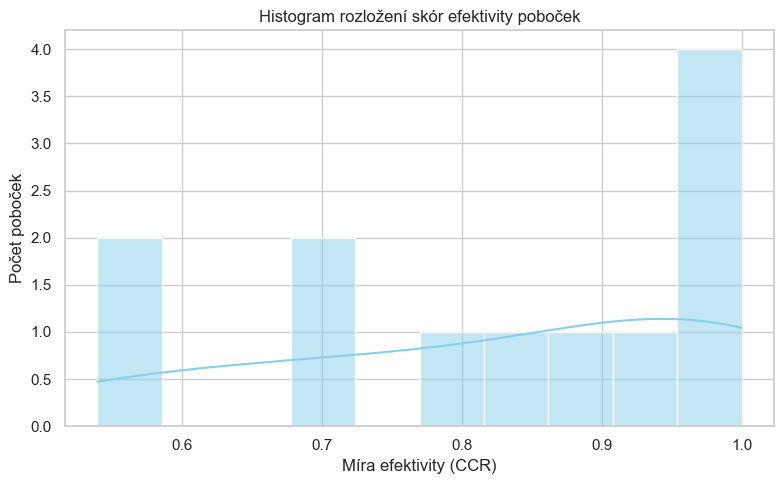

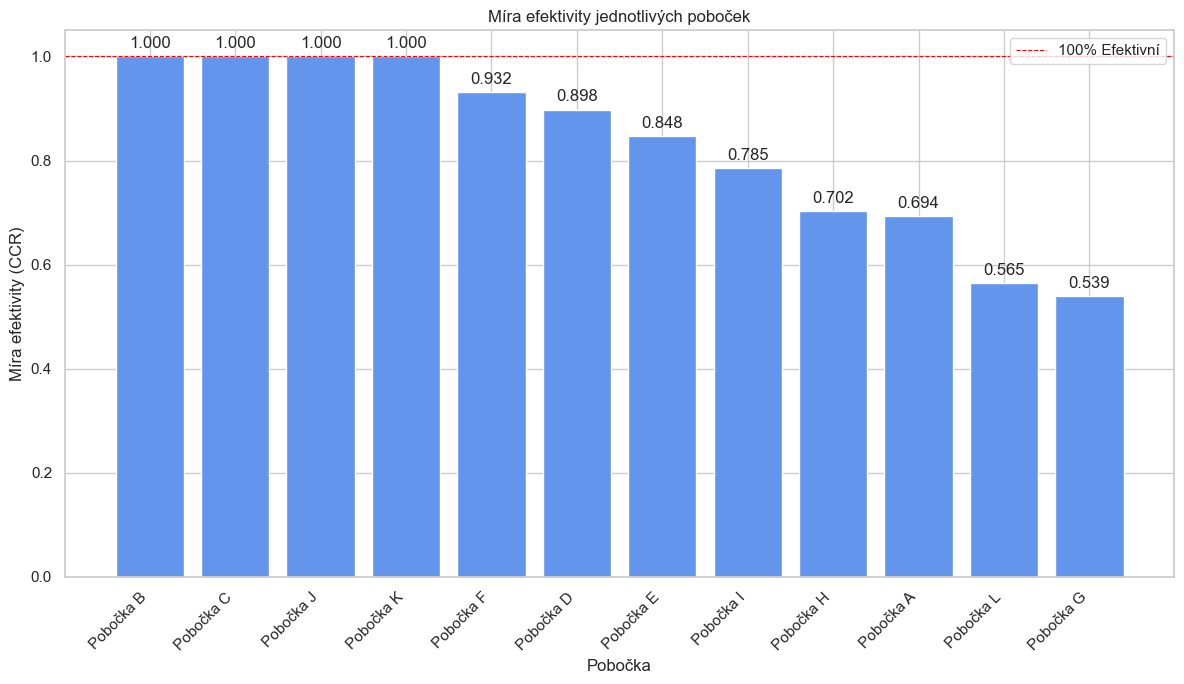

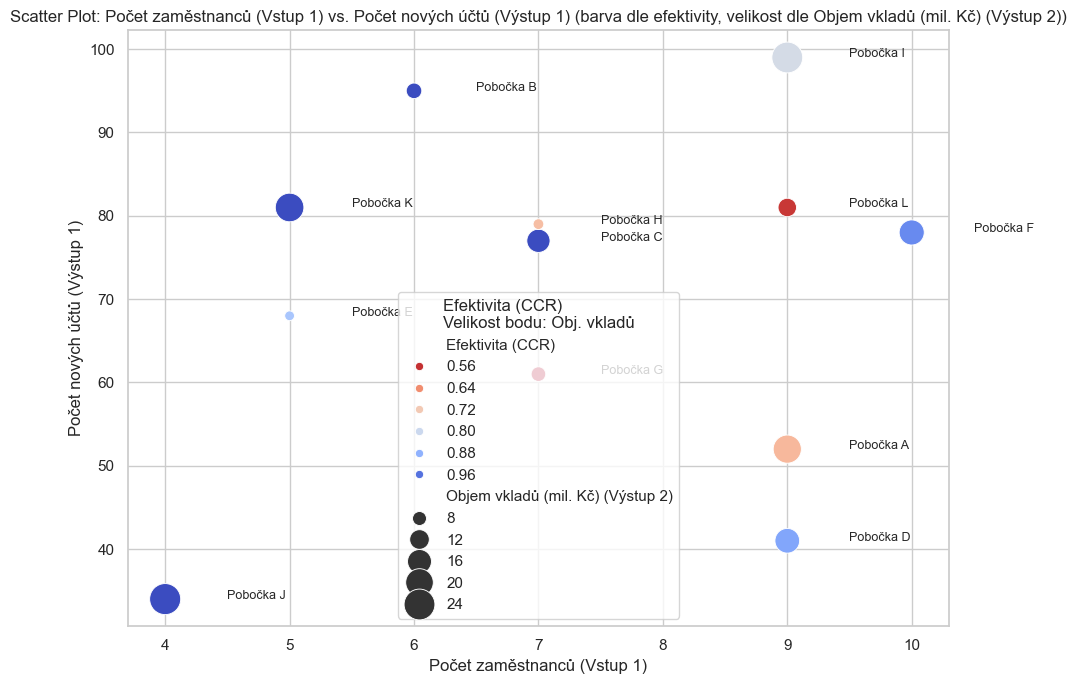

--- Analýza neefektivních jednotek, cílové hodnoty a vizualizace peerů ---

--- Pobočka: Pobočka A (Efektivita: 0.6937) ---
  Počet zaměstnanců (Vstup 1):
    Současná hodnota: 9.00
    Cílová hodnota:   6.24 (snížení o 2.76, tj. o 30.63%)
  Provozní náklady (tis. Kč) (Vstup 2):
    Současná hodnota: 480.00
    Cílová hodnota:   332.96 (snížení o 147.04, tj. o 30.63%)


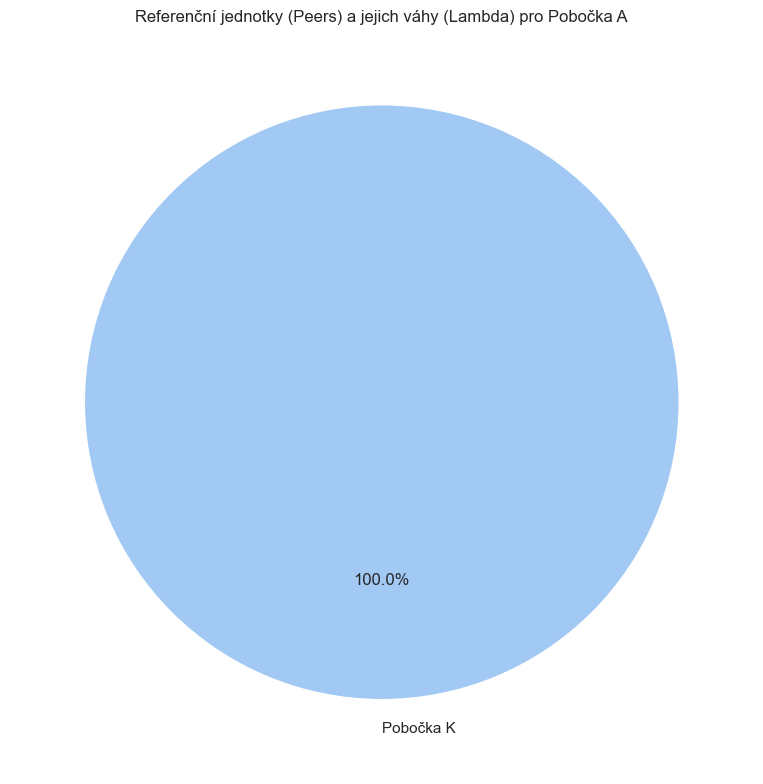

Charakteristiky virtuální efektivní jednotky (složené z peers):

--- Pobočka: Pobočka D (Efektivita: 0.8978) ---
  Počet zaměstnanců (Vstup 1):
    Současná hodnota: 9.00
    Cílová hodnota:   8.08 (snížení o 0.92, tj. o 10.22%)
  Provozní náklady (tis. Kč) (Vstup 2):
    Současná hodnota: 301.00
    Cílová hodnota:   270.23 (snížení o 30.77, tj. o 10.22%)
Charakteristiky virtuální efektivní jednotky (složené z peers):

--- Pobočka: Pobočka E (Efektivita: 0.8477) ---
  Počet zaměstnanců (Vstup 1):
    Současná hodnota: 5.00
    Cílová hodnota:   4.24 (snížení o 0.76, tj. o 15.23%)
  Provozní náklady (tis. Kč) (Vstup 2):
    Současná hodnota: 280.00
    Cílová hodnota:   237.35 (snížení o 42.65, tj. o 15.23%)
Charakteristiky virtuální efektivní jednotky (složené z peers):

--- Pobočka: Pobočka F (Efektivita: 0.9317) ---
  Počet zaměstnanců (Vstup 1):
    Současná hodnota: 10.00
    Cílová hodnota:   9.32 (snížení o 0.68, tj. o 6.83%)
  Provozní náklady (tis. Kč) (Vstup 2):
    Současná 

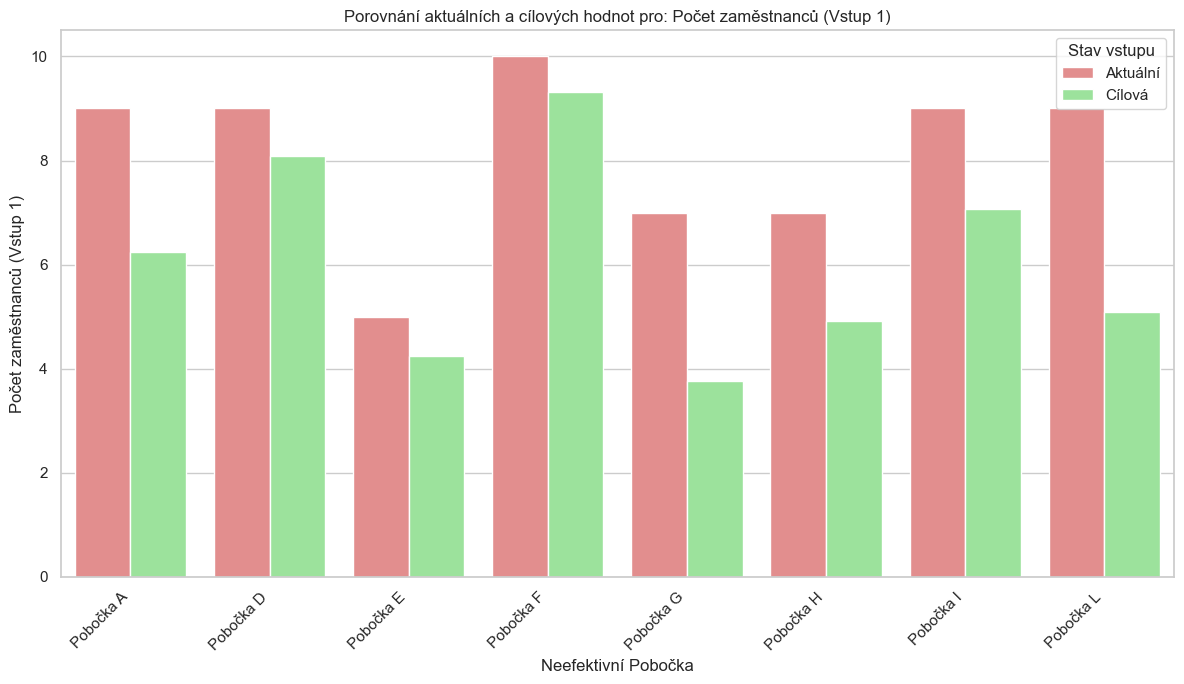

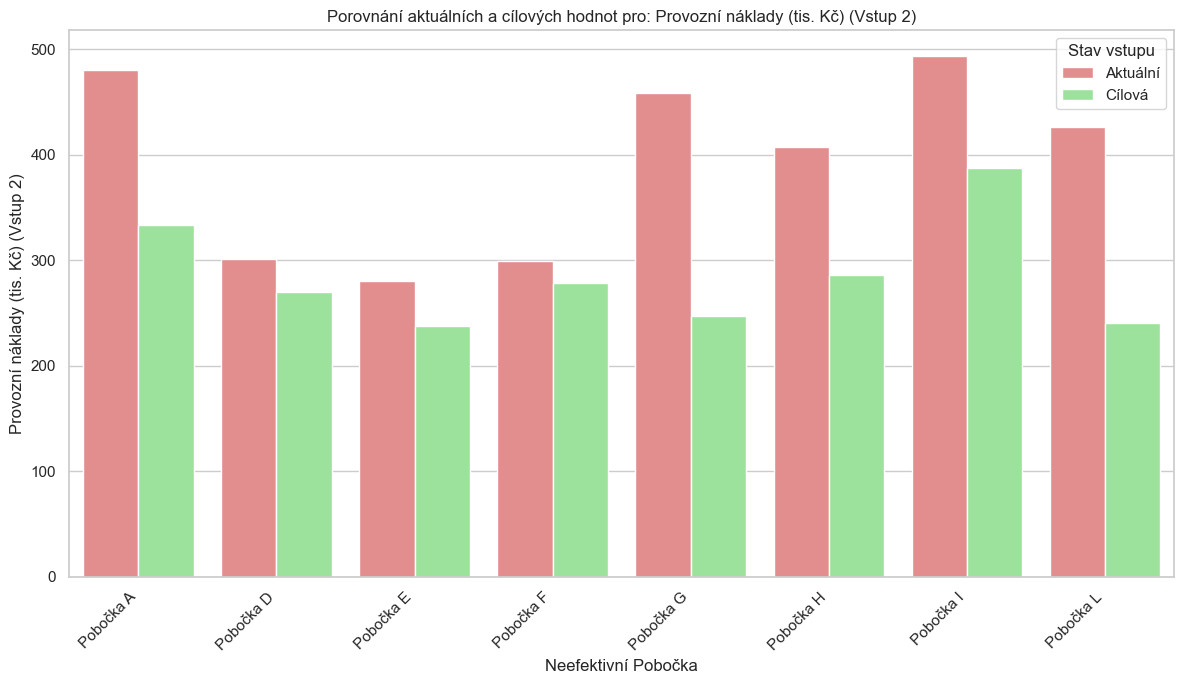



--- Komentář k získaným výsledkům ---
Celkem bylo hodnoceno 12 poboček na základě čistě náhodně generovaných dat.
4 poboček je 100% efektivních podle CCR modelu (input-oriented).
8 poboček je neefektivních a mají potenciál pro zlepšení.

Pobočky s nejvyšší efektivitou jsou benchmarkem pro ostatní.
Neefektivní pobočky mohou dosáhnout plné efektivity snížením svých vstupů na cílové hodnoty, aniž by snížily své výstupy.
Vizualizace pomáhají lépe identifikovat odchylky a cíle pro zlepšení.
Výsledky nyní plně odrážejí náhodně generovaná data. Počet efektivních a neefektivních jednotek, stejně jako konkrétní cílové hodnoty, se mohou lišit od předchozí verze s upravenými daty.
Scatter plot může pomoci identifikovat pobočky, které jsou 'odlehlé' v kontextu jejich vstupů a výstupů.
Koláčový graf peerů (zobrazen pro první neefektivní pobočku s peery) ukazuje, které efektivní pobočky tvoří referenční skupinu pro danou neefektivní jednotku.
Je důležité poznamenat, že DEA je citlivá na výběr vstu

In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# Nastavení stylu pro grafy (volitelné)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Výchozí velikost grafů

# --- 1. Formulace vlastní úlohy a generování dat ---
# Alespoň 12 jednotek, minimálně 2 vstupy a 2 výstupy

# Počet DMU (poboček)
n_dmus = 12
dmu_names = [f"Pobočka {chr(65+i)}" for i in range(n_dmus)]

# Generování náhodných dat
np.random.seed(42) # Pro reprodukovatelnost

data = {
    'Pobočka': dmu_names,
    'Počet zaměstnanců (Vstup 1)': np.random.randint(3, 11, size=n_dmus),
    'Provozní náklady (tis. Kč) (Vstup 2)': np.random.randint(150, 501, size=n_dmus),
    'Počet nových účtů (Výstup 1)': np.random.randint(20, 101, size=n_dmus),
    'Objem vkladů (mil. Kč) (Výstup 2)': np.round(np.random.uniform(5, 25, size=n_dmus), 1)
}
df = pd.DataFrame(data)

# ODSTRANILI JSME ČÁST, KTERÁ ÚMYSLNĚ MĚNILA DATA PRO NĚKTERÉ POBOČKY

print("--- Data pro analýzu (čistě náhodná) ---")
print(df)
print("\n")

# Definice vstupů a výstupů
inputs = ['Počet zaměstnanců (Vstup 1)', 'Provozní náklady (tis. Kč) (Vstup 2)']
outputs = ['Počet nových účtů (Výstup 1)', 'Objem vkladů (mil. Kč) (Výstup 2)']

# --- 2. Výpočet míry efektivnosti (CCR model, input-oriented) ---
efficiency_scores = {}
peer_weights = {}

input_data = df[inputs].values
output_data = df[outputs].values
num_inputs = len(inputs)
num_outputs = len(outputs)

for o in range(n_dmus):
    prob = pulp.LpProblem(f"DEA_DMU_{o}", pulp.LpMinimize)
    theta = pulp.LpVariable(f"theta_{o}", lowBound=0)
    lambdas = [pulp.LpVariable(f"lambda_{o}_{j}", lowBound=0) for j in range(n_dmus)]
    prob += theta, "Míra efektivity"
    for i in range(num_inputs):
        prob += pulp.lpSum(lambdas[j] * input_data[j, i] for j in range(n_dmus)) <= theta * input_data[o, i], f"Vstup_constraint_{i}_DMU_{o}"
    for r in range(num_outputs):
        prob += pulp.lpSum(lambdas[j] * output_data[j, r] for j in range(n_dmus)) >= output_data[o, r], f"Výstup_constraint_{r}_DMU_{o}"
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    efficiency_scores[df['Pobočka'].iloc[o]] = pulp.value(theta)
    peer_weights[df['Pobočka'].iloc[o]] = {df['Pobočka'].iloc[j]: pulp.value(lambdas[j]) for j in range(n_dmus) if pulp.value(lambdas[j]) > 1e-5}

df['Efektivita (CCR)'] = df['Pobočka'].map(efficiency_scores)
df_sorted_efficiency = df.sort_values(by='Efektivita (CCR)', ascending=False)

print("--- Výsledky efektivity (tabulka) ---")
print(df_sorted_efficiency[['Pobočka', 'Efektivita (CCR)']])
print("\n")


# --- VIZUALIZACE VÝSLEDKŮ EFEKTIVITY ---

# 1. Histogram rozložení skór efektivity
plt.figure(figsize=(8, 5))
sns.histplot(df['Efektivita (CCR)'], bins=10, kde=True, color='skyblue')
plt.title('Histogram rozložení skór efektivity poboček')
plt.xlabel('Míra efektivity (CCR)')
plt.ylabel('Počet poboček')
plt.tight_layout()
plt.show()

# 2. Sloupcový graf skór efektivity pro každou pobočku
plt.figure(figsize=(12, 7))
bars = plt.bar(df_sorted_efficiency['Pobočka'], df_sorted_efficiency['Efektivita (CCR)'], color='cornflowerblue')
plt.xlabel('Pobočka')
plt.ylabel('Míra efektivity (CCR)')
plt.title('Míra efektivity jednotlivých poboček')
plt.xticks(rotation=45, ha="right")
plt.axhline(1.0, color='red', linestyle='--', linewidth=0.8, label='100% Efektivní')
# Přidání hodnot nad sloupce
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Scatter plot (příklad: Vstup 1 vs. Výstup 1)
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=df[inputs[0]],
    y=df[outputs[0]],
    hue=df['Efektivita (CCR)'],
    size=df[outputs[1]],
    sizes=(50, 500),
    palette="coolwarm_r",
    legend="brief"
)
plt.title(f'Scatter Plot: {inputs[0]} vs. {outputs[0]} (barva dle efektivity, velikost dle {outputs[1]})')
plt.xlabel(inputs[0])
plt.ylabel(outputs[0])

for i in range(df.shape[0]):
    plt.text(df[inputs[0]][i] + 0.05 * df[inputs[0]].max(),
             df[outputs[0]][i],
             df['Pobočka'][i],
             fontsize=9)
plt.legend(title='Efektivita (CCR)\nVelikost bodu: Obj. vkladů')
plt.tight_layout()
plt.show()


# --- 3. Cílové hodnoty pro neefektivní jednotky a vizualizace ---
print("--- Analýza neefektivních jednotek, cílové hodnoty a vizualizace peerů ---")
inefficient_dmus_df = df[df['Efektivita (CCR)'] < 0.99999].copy()

if inefficient_dmus_df.empty:
    print("Všechny jednotky jsou efektivní.")
else:
    plot_data_inputs = []
    first_inefficient_processed_for_pie = False # Flag pro zobrazení koláčového grafu jen jednou

    for index, row in inefficient_dmus_df.iterrows():
        dmu_name = row['Pobočka']
        current_efficiency = row['Efektivita (CCR)']
        print(f"\n--- Pobočka: {dmu_name} (Efektivita: {current_efficiency:.4f}) ---")

        target_inputs_dict = {}
        for i_idx, input_name in enumerate(inputs):
            current_input_value = input_data[index, i_idx]
            target_input_value = current_input_value * current_efficiency
            target_inputs_dict[input_name] = target_input_value
            reduction_needed = current_input_value - target_input_value
            print(f"  {input_name}:")
            print(f"    Současná hodnota: {current_input_value:.2f}")
            print(f"    Cílová hodnota:   {target_input_value:.2f} (snížení o {reduction_needed:.2f}, tj. o {(1-current_efficiency)*100:.2f}%)")
            
            plot_data_inputs.append({'Pobočka': dmu_name, 'Typ vstupu': input_name, 'Hodnota': current_input_value, 'Stav': 'Aktuální'})
            plot_data_inputs.append({'Pobočka': dmu_name, 'Typ vstupu': input_name, 'Hodnota': target_input_value, 'Stav': 'Cílová'})

        # 4. Koláčový graf vah peerů (pro první neefektivní pobočku jako příklad)
        if not first_inefficient_processed_for_pie and dmu_name in peer_weights and peer_weights[dmu_name]:
            peers = peer_weights[dmu_name]
            peer_names = list(peers.keys())
            weights = list(peers.values())

            if sum(weights) > 0:
                plt.figure(figsize=(8, 8))
                plt.pie(weights, labels=peer_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
                plt.title(f'Referenční jednotky (Peers) a jejich váhy (Lambda) pro {dmu_name}')
                plt.tight_layout()
                plt.show()
                first_inefficient_processed_for_pie = True # Změna flagu
        elif not first_inefficient_processed_for_pie:
             print(f"  Pro {dmu_name} (první neefektivní) nebyly nalezeny žádné specifické referenční jednotky s nenulovou váhou pro koláčový graf, nebo je to efektivní jednotka.")
             if dmu_name in peer_weights and not peer_weights[dmu_name]: # Pokud je v peer_weights, ale slovník je prázdný
                 first_inefficient_processed_for_pie = True # Označíme, že jsme se pokusili
                 
        print("Charakteristiky virtuální efektivní jednotky (složené z peers):")
        # (můžete doplnit výpis charakteristik, pokud je potřeba)

    if plot_data_inputs:
        df_plot_inputs = pd.DataFrame(plot_data_inputs)
        for input_name_to_plot in inputs:
            plt.figure(figsize=(12, 7))
            subset_plot_df = df_plot_inputs[df_plot_inputs['Typ vstupu'] == input_name_to_plot]
            sns.barplot(x='Pobočka', y='Hodnota', hue='Stav', data=subset_plot_df, palette={'Aktuální': 'lightcoral', 'Cílová': 'lightgreen'})
            plt.title(f'Porovnání aktuálních a cílových hodnot pro: {input_name_to_plot}')
            plt.xlabel('Neefektivní Pobočka')
            plt.ylabel(input_name_to_plot)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title='Stav vstupu')
            plt.tight_layout()
            plt.show()

print("\n\n--- Komentář k získaným výsledkům ---")
num_efficient = df[df['Efektivita (CCR)'] >= 0.99999].shape[0]
print(f"Celkem bylo hodnoceno {n_dmus} poboček na základě čistě náhodně generovaných dat.")
print(f"{num_efficient} poboček je 100% efektivních podle CCR modelu (input-oriented).")
print(f"{n_dmus - num_efficient} poboček je neefektivních a mají potenciál pro zlepšení.")
print("\nPobočky s nejvyšší efektivitou jsou benchmarkem pro ostatní.")
print("Neefektivní pobočky mohou dosáhnout plné efektivity snížením svých vstupů na cílové hodnoty, aniž by snížily své výstupy.")
print("Vizualizace pomáhají lépe identifikovat odchylky a cíle pro zlepšení.")
print("Výsledky nyní plně odrážejí náhodně generovaná data. Počet efektivních a neefektivních jednotek, stejně jako konkrétní cílové hodnoty, se mohou lišit od předchozí verze s upravenými daty.")
print("Scatter plot může pomoci identifikovat pobočky, které jsou 'odlehlé' v kontextu jejich vstupů a výstupů.")
print("Koláčový graf peerů (zobrazen pro první neefektivní pobočku s peery) ukazuje, které efektivní pobočky tvoří referenční skupinu pro danou neefektivní jednotku.")
print("Je důležité poznamenat, že DEA je citlivá na výběr vstupů a výstupů a na kvalitu dat. Výsledky by měly být interpretovány v kontextu a případně doplněny další kvalitativní analýzou.")
print("Tento CCR model předpokládá konstantní výnosy z rozsahu (CRS). Pro analýzu, která zohledňuje variabilní výnosy z rozsahu (VRS), by bylo nutné použít BCC model.")